In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np

In [Melbourne Airbnb Price Prediction](https://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26586189.pdf ) they only use text and non-text data that are stored in cleansed_listings_dec18.csv and text data from reviews_dec18.csv.

In [2]:
clean_listings = pd.read_csv(
    '../data/raw/airbnb/cleansed_listings_dec18.csv', low_memory=False)
useless_cols = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_url', 'host_id',
                'host_name', 'host_thumbnail_url', 'host_picture_url', 'country_code', 'country',
                'is_location_exact', 'calendar_updated','cancellation_policy', 'instant_bookable', 
                'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 'license',
                'has_availability', 'zipcode', 'host_has_profile_pic', 'host_identity_verified',
                'state','host_location','street', 'suburb','smart_location', 'require_guest_profile_picture',
                'require_guest_phone_verification']
clean_listings.drop(useless_cols, axis=1, inplace=True)
clean_listings.dropna(axis='columns', thresh=round(0.8*len(clean_listings)), inplace=True)
clean_listings.shape

(22895, 28)

In [3]:
# Drop rows where price is 0 or over 1000
clean_listings = clean_listings[(clean_listings.price>0) & (clean_listings.price<1000)]
clean_listings['#host_verifications'] = clean_listings[['host_verifications']].applymap(lambda x: len(x.split(',')))
clean_listings.drop('host_verifications', axis=1, inplace=True)

# get all unique amenities
amenities = set()
for i in clean_listings['amenities']:
    fts = i[1:-1].split(',')
    for ft in fts:
        amenities.add(re.sub(r'["{}]', '', ft).strip())
amenities.remove('')

def get_amenities(amenity):
    fts = amenity[1:-1].split(',')
    fts = [re.sub(r'["{}]', '', ft).strip() for ft in fts]
    return fts
clean_listings['amenities'] = clean_listings['amenities'].apply(get_amenities)

# Turn amenities into binary features
for amenity in tqdm(amenities):
    clean_listings[amenity] = clean_listings['amenities'].apply(lambda x: 1 if amenity in x else 0)
    
clean_listings.drop('amenities', axis=1, inplace=True)

clean_listings['host_since'] = pd.to_datetime(clean_listings['host_since'])
# Turn host_since into number of days since clean_listings['host_since'].min()
clean_listings['host_since'] = (clean_listings['host_since'] - clean_listings['host_since'].min()).dt.days

 49%|████▉     | 92/187 [00:01<00:01, 66.28it/s]/tmp/ipykernel_44346/407891736.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clean_listings[amenity] = clean_listings['amenities'].apply(lambda x: 1 if amenity in x else 0)
/tmp/ipykernel_44346/407891736.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clean_listings[amenity] = clean_listings['amenities'].apply(lambda x: 1 if amenity in x else 0)
/tmp/ipykernel_44346/407891736.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

## Categorical features

In [4]:
categorical_fts = ['bed_type', 'room_type', 'property_type', 'city']
clean_listings[categorical_fts].nunique()

bed_type          5
room_type         3
property_type    35
city             30
dtype: int64

In [5]:
# Turn categorical features into dummy variables
for col in categorical_fts:
    clean_listings = pd.concat([clean_listings, pd.get_dummies(clean_listings[col], prefix=col)], axis=1)
    clean_listings.drop(col, axis=1, inplace=True)
    
# change host_is_superhost to binary
clean_listings['host_is_superhost'] = clean_listings['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
clean_listings.dropna(axis='rows', inplace=True)

## Predict using only non-text features

In [6]:
text_features = ['name', 'summary', 'description']

In [7]:
Y = clean_listings['price']
X = clean_listings.drop(text_features+['price'], axis=1)

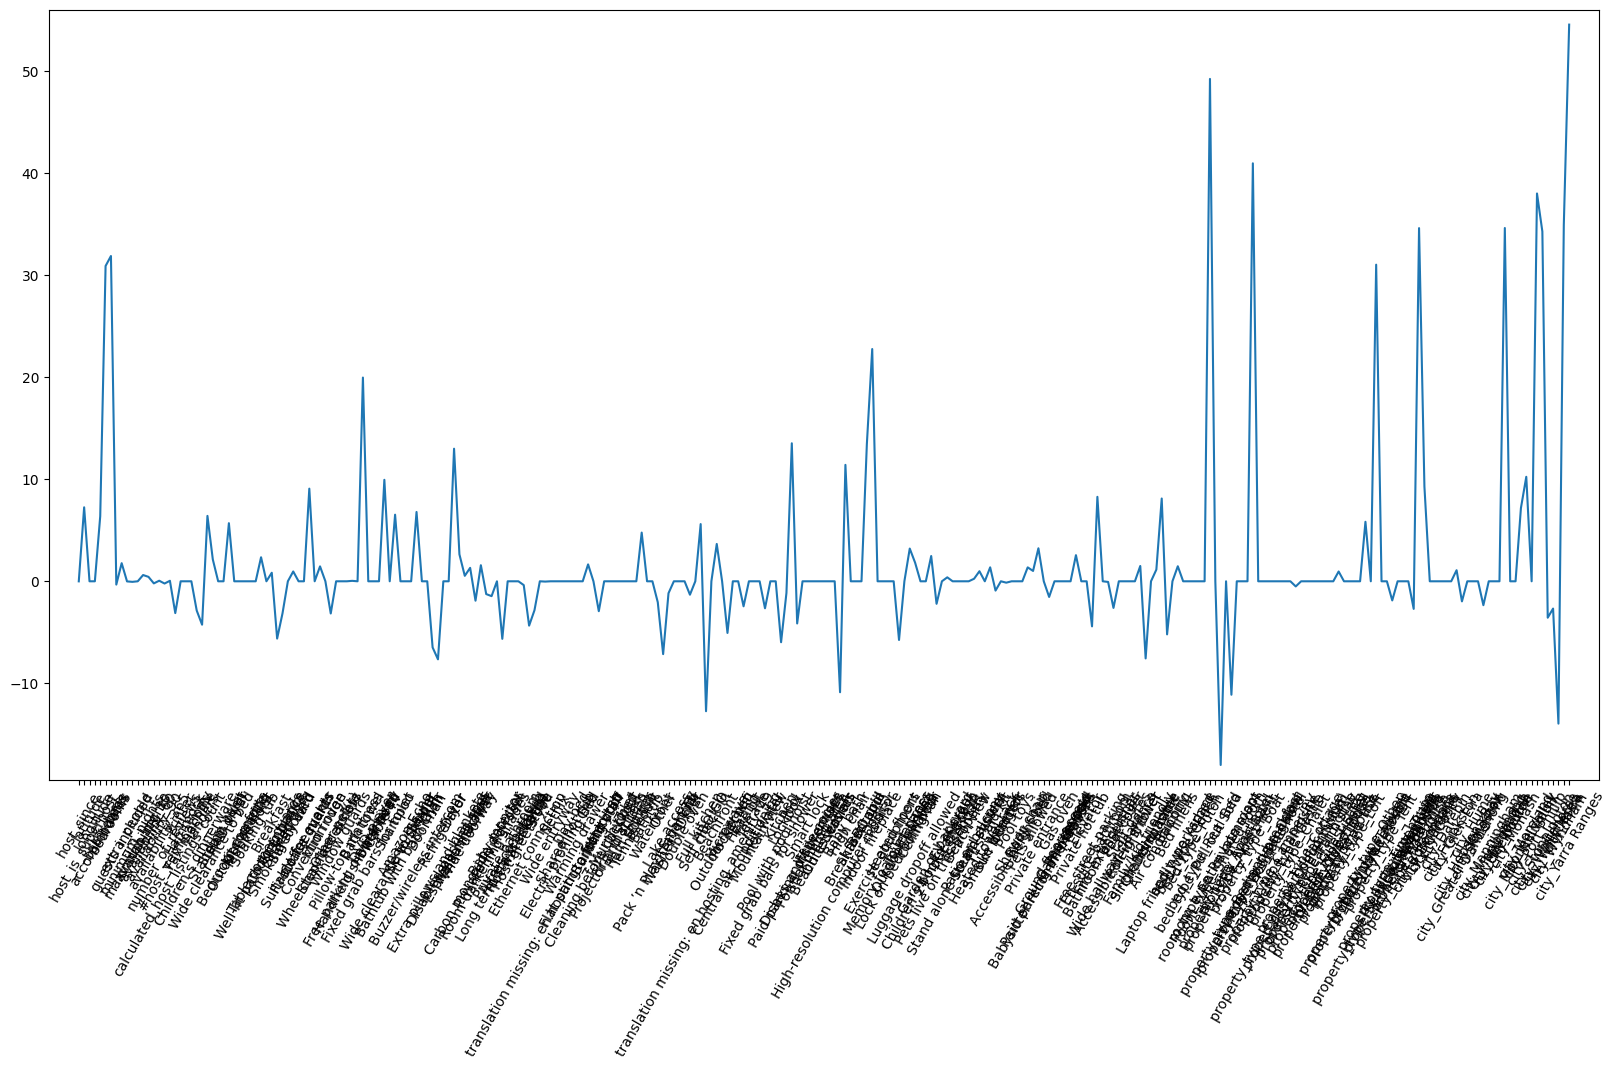

In [8]:
# Perform lasso to select features
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Plot the coefficients
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(range(len(X.columns)), lasso_coef)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.margins(0.02)
plt.show()


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

RMSE:  85.23036991610208
0.46587344526325203


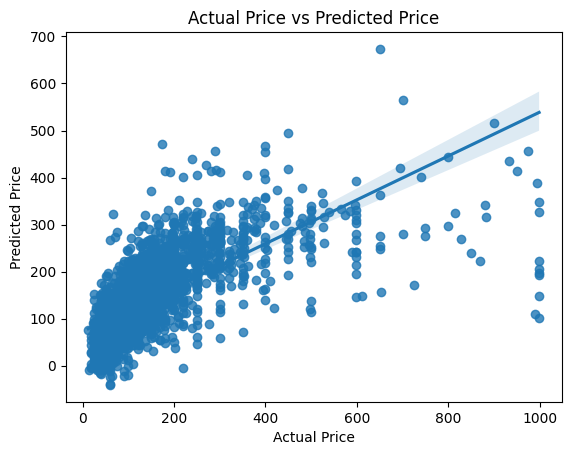

In [10]:

# Select features with non-zero coefficients
selected_fts = X.columns[lasso_coef!=0]

# fit a linear regression model

X_train, X_test, y_train, y_test = train_test_split(X[selected_fts], Y, test_size=0.15, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

# Caluclate the R-squared
print(r2_score(y_test, y_pred))

# Plot y vs y_pred on seaborn

sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()



## Plot without feature selection

RMSE:  85.23036991610208
R^2:  0.46587344526325203


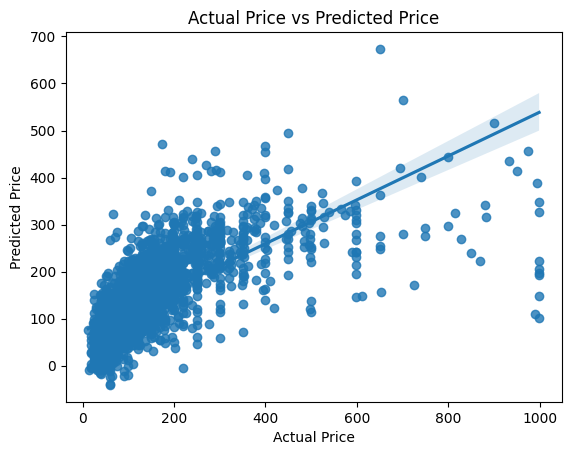

In [11]:
Y = clean_listings['price']
X = clean_listings.drop(text_features+['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X[selected_fts], Y, test_size=0.15, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

# Caluclate the R-squared
print('R^2: ',r2_score(y_test, y_pred))

# Plot y vs y_pred on seaborn

sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()

## xGBoost

In [12]:
# Fit xgboost model
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: ',r2_score(y_test, y_pred))

RMSE:  73.63904875384192
R^2:  0.6012765643484442


## Predict using only text features

# Steps
* model is imported from the transformers lib
* 


In [14]:
from datasets import Dataset, DatasetDict
import torch
from transformers import BertTokenizer, BertForSequenceClassification


def combine_text_columns(data):
    # data['input'] = data['name'] + ' ' + data['summary'] + ' ' + data['description']
    data['text'] = data['description']
    return data

X_text = Dataset.from_pandas(clean_listings[text_features][:100]).map(combine_text_columns)
X_text = X_text.remove_columns(['__index_level_0__', 'name', 'summary', 'description'])
X_text = X_text.add_column('label', Y[:100].astype('float32'))

# Train test split
train_test = X_text.train_test_split(test_size=0.15, shuffle=True, seed=42)
train_validation = train_test['train'].train_test_split(test_size=0.15/0.85, shuffle=True, seed=42)
X_text = DatasetDict({'train': train_validation['train'], 'validation': train_validation['test'], 'test': train_test['test']})
# X_text.save_to_disk('../data/processed/airbnb/summaries')


In [15]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1, problem_type='regression')
# model = torch.compile(model) # This line is for PyTorch 2.0

X_text = X_text.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
from lion_pytorch import Lion
from transformers import Trainer, TrainingArguments, get_linear_schedule_with_warmup
args = TrainingArguments(
    output_dir="../models/airbnb",  # output directory
    num_train_epochs=3,  # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,  # batch size for evaluation
    remove_unused_columns=False,
)
opt = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = get_linear_schedule_with_warmup(opt, num_warmup_steps=args.warmup_steps, num_training_steps=args.max_steps)
trainer = Trainer(
    optimizers=(opt, None),
    model=model,
    args=args,
    train_dataset=X_text["train"],
    eval_dataset=X_text["test"],
)
trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 15
  Batch size = 16
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


{'eval_loss': 14782.3623046875,
 'eval_runtime': 0.2724,
 'eval_samples_per_second': 55.064,
 'eval_steps_per_second': 3.671}

In [15]:
Y.astype('float32')

1         35.0
2        159.0
3         50.0
5         98.0
6         50.0
         ...  
22890     55.0
22891    129.0
22892     53.0
22893    130.0
22894    179.0
Name: price, Length: 22057, dtype: float32

In [16]:
X_text["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 69
})

In [17]:
X_text.save_to_disk('../data/processed/airbnb/summaries')

In [18]:
from datasets import load_dataset, load_from_disk

ds = load_from_disk('../data/processed/airbnb/summaries')

In [19]:
ds['train']['labe']

KeyError: "Column labe not in the dataset. Current columns in the dataset: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']"